In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm.autonotebook import tqdm
import gym
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def moving_average(values, n=100) :
    ret = np.cumsum(values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
env = gym.make('FrozenLake-v0')
policy_to_action = {0:"L",1:"D",2:"R",3:"U"}

In [4]:
ACTION_DIM = env.action_space.n
MAX_STEPS = env.spec.max_episode_steps
STATE_DIM = env.observation_space.n
NUM_EPISODES = 1000000
START_ALPHA = 0.1
ALPHA_TAPER = 0.01
START_EPSILON = 1
EPSILON_TAPER = 0.0001
GAMMA = 0.9

In [5]:
Q = np.zeros((STATE_DIM,ACTION_DIM),dtype=np.float64)
state_visits_count = {}
update_counts = np.zeros((STATE_DIM,ACTION_DIM),dtype=np.int64)
def updateQ( prev_state,action,reward,cur_state):
    alpha = START_ALPHA / ( 1 + update_counts[prev_state][action]*ALPHA_TAPER )
    update_counts[prev_state][action] += 1
    Q[prev_state][action] += alpha * ( reward + GAMMA * np.max(Q[cur_state]) - Q[prev_state][action] )
    
def epsilon_greedy(s,eps=START_EPSILON):
    if np.random.random() > 1-eps:
        return np.argmax(Q[s])
    else:
        return env.action_space.sample()

EPISODES : 0 | AVG_REWARD : 0.0 | EPSILON : 1.0
EPISODES : 100000 | AVG_REWARD : 0.02528 | EPSILON : 0.09090909090909091
EPISODES : 200000 | AVG_REWARD : 0.01686 | EPSILON : 0.047619047619047616
EPISODES : 300000 | AVG_REWARD : 0.01593 | EPSILON : 0.03225806451612903
EPISODES : 400000 | AVG_REWARD : 0.01513 | EPSILON : 0.024390243902439025
EPISODES : 500000 | AVG_REWARD : 0.01556 | EPSILON : 0.0196078431372549
EPISODES : 600000 | AVG_REWARD : 0.01479 | EPSILON : 0.01639344262295082
EPISODES : 700000 | AVG_REWARD : 0.01429 | EPSILON : 0.014084507042253521
EPISODES : 800000 | AVG_REWARD : 0.0146 | EPSILON : 0.012345679012345678
EPISODES : 900000 | AVG_REWARD : 0.01432 | EPSILON : 0.01098901098901099

EACH STATE WAS VISITED 720285.6363636364 TIMES ON AN AVERAGE
TIME TAKEN 377.6350088119507 
Optimal Policy :
 [['L' 'U' 'L' 'U']
 ['L' 'L' 'L' 'L']
 ['U' 'D' 'L' 'L']
 ['L' 'R' 'D' 'L']] 
Optimal Values :
 [[0.06974745 0.06229239 0.07561941 0.05673794]
 [0.09303173 0.         0.11284137 0.   

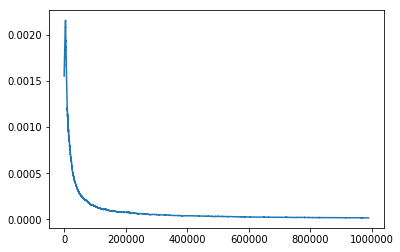

In [6]:
total_rewards = 0 
deltas = []
verbose = True

start = time.time()

for episode in tqdm(range(NUM_EPISODES),desc = "Progress : "):
    eps = START_EPSILON / ( 1.0 + EPSILON_TAPER * episode )
    if verbose and episode % (NUM_EPISODES/10) == 0:
        print("EPISODES : {} | AVG_REWARD : {} | EPSILON : {}".format(episode,total_rewards/(NUM_EPISODES/10),eps))
        total_rewards=0
    
    biggest_change = 0
    curr_state = env.reset()
    for _ in range(MAX_STEPS):
        action = epsilon_greedy(curr_state,eps=eps)
        state_visits_count[curr_state] = state_visits_count.get(curr_state,0)+1
        prev_state = curr_state
        curr_state, reward, done, _ = env.step(action)
        total_rewards += reward
        oldq = Q[prev_state][action]
        updateQ(prev_state,action,reward,curr_state)
        biggest_change = max( biggest_change , np.abs( oldq - Q[prev_state][action] ))
        if done:
            break
    deltas.append(biggest_change)

mean_state_visit = np.mean( list(state_visits_count.values()) )
print('EACH STATE WAS VISITED {} TIMES ON AN AVERAGE'.format( mean_state_visit ))

Value_F = np.zeros(STATE_DIM)
Policy_F = np.zeros(STATE_DIM)
for s in range(STATE_DIM):
    Value_F[s] = np.max(Q[s])
    Policy_F[s] = np.argmax(Q[s])

print("TIME TAKEN {} ".format(time.time()-start))
    
gpolicy = list(map(lambda a: policy_to_action[a],Policy_F))
print("Optimal Policy :\n {} ".format(np.reshape(gpolicy,(int(np.sqrt(STATE_DIM)),int(np.sqrt(STATE_DIM))))))
print("Optimal Values :\n {}".format(np.reshape(Value_F,(int(np.sqrt(STATE_DIM)),int(np.sqrt(STATE_DIM))))))

plt.plot(moving_average(deltas,n=10000))
plt.show()

In [7]:
"""
Lets see our success rate
"""
games = 1000
won = 0
for _ in range(games):
    state = env.reset()
    while True:
        action = int(Policy_F[state])
        (state,reward,is_done,_) = env.step(action)
        if is_done:
            if reward>0:
                won+=1
            env.close()
            break
            
print("Success Rate : {}".format(won/games))

Success Rate : 0.723
